## Batch Normalization!! Accelarating Deep Network Training by Reducing Internal Covariate Shift
---
- **What is Internal Covariate Shift?**
  - The change in distributions of internal nodes/hidden layer activations (due to change in network parameters during training) of a deep network, in the course of training is called Internal Covariate Shift.
  - It causes due to, as weights are updated during training, the input distribution of deeper layers changes, leading to instability.
  - Which leads to slower convergence and increased reliance on careful weight initialization.
  - Eliminating this offers faster training. And Batch Normalization is a method to do it.
  - It dramatically accelarates the training of deep neural nets.
---
- **How BN is achieved?**
  - It operates by calculating mean and variance of the activations for each feature in the mini-batch and then normalizing the activations using these stats.
  - The normalized activations are then scaled and shifted using learnable parameters, allowing the model to adapt to the optimal activation distribution.
   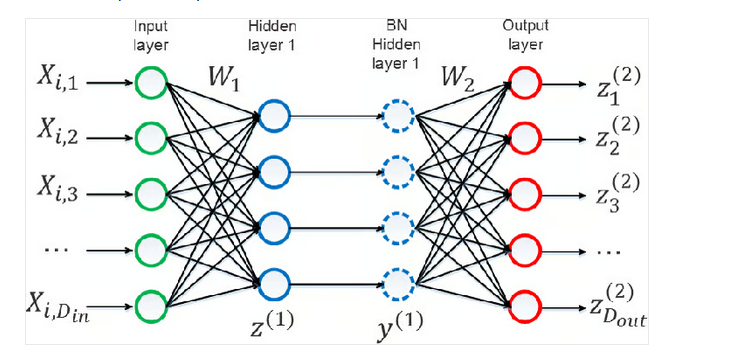
  - Normalization step that fixes the means and variances of layer inputs.
  - It is typically applied after the linear transformation of a layer (after the matrix multiplication of in a fully connected layer) or before the non linear activation function(eg. ReLU).
---
- **Batch Normalization during Training**
- Here we apply batch normalization to activation x over a mini batch.
- The mathematical representation can be shown like:
1. Compute the mini-batch mean:
Batch Normalization (BN) helps neural networks train faster and generalize better by normalizing activations. 
The process is as follows:

1. Compute the mini-batch mean:
   $$ \mu_B = \frac{1}{m} \sum_{i=1}^{m} x_i $$

2. Compute the mini-batch variance:
   $$ \sigma_B^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_B)^2 $$

3. Normalize each input:
   $$ \hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}} $$

4. Scale and shift using learnable parameters ($\gamma, \beta$):
   $$ y_i = \gamma \hat{x}_i + \beta $$

Here, $ \epsilon $ is a small constant to prevent division by zero.   

These paramters allows the model to learn the optimal activation distribution.
---
**Batch normalization during inference**
- During inference, we replace the batch statistics (mean and variance) with the running statistics computed during training.
- They are typically updated using a moving average with a momentum vector.

- To calculate running mean and variance we can use two formulas, where $\alpha$ is the momentum factor that controls the update rate of the running statistics:
  $$ \mu_r = \alpha \mu_r + (1 - \alpha) \mu_B $$
  $$ \sigma^2_r = \alpha \sigma^2_r + (1 - \alpha) \sigma^2_B $$
- Here $ \mu_r $ and $ \sigma_r $ are running mean and variance which are stores as model parameters and used for normalization during inference.
- The scaling and shifting parameters ($\gamma and \beta$) learned during training also used during inference

### References: 
- [Datacamp Blog](https://www.datacamp.com/tutorial/batch-normalization-tensorflow)
- [Batch Norm Paper](https://arxiv.org/pdf/1502.03167)

## Let's implement two models with BN and without BN and compare their performances. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST 
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████| 9912422/9912422 [00:21<00:00, 452321.26it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████| 28881/28881 [00:00<00:00, 106975.46it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████| 1648877/1648877 [00:04<00:00, 407244.34it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 1569882.88it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# Define models
class NetWithoutBN(nn.Module):
    def __init__(self):
        super(NetWithoutBN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
class NetWithBN(nn.Module):
    def __init__(self):
        super(NetWithBN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x


In [5]:
# Training function
def train_and_evaluate(model, optimizer, criterion, trainloader, testloader, epochs=10):
    model.to(device)
    train_acc, test_acc = [], []
    activation_distributions = {15: [], 50: [], 85: []}
    
    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_acc.append(correct / total)
        
        # Evaluate model
        model.eval()
        correct, total = 0, 0
        
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_acc.append(correct / total)

        
        if epoch + 1 in activation_distributions:
            with torch.no_grad():
                sample_images, _ = next(iter(trainloader))
                sample_images = sample_images.to(device)
                activations = model(sample_images).cpu().numpy()
                activation_distributions[epoch + 1] = activations
                
        print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_acc[-1]:.4f}, Test Acc: {test_acc[-1]:.4f}")
    
    return train_acc, test_acc, activation_distributions

In [6]:
# Train models
model_without_bn = NetWithoutBN()
optimizer_without_bn = optim.Adam(model_without_bn.parameters(), lr=0.001)

model_with_bn = NetWithBN()
optimizer_with_bn = optim.Adam(model_with_bn.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

train_acc_no_bn, test_acc_no_bn, activations_no_bn = train_and_evaluate(model_without_bn, optimizer_without_bn, criterion, trainloader, testloader)
train_acc_bn, test_acc_bn, activations_bn = train_and_evaluate(model_with_bn, optimizer_with_bn, criterion, trainloader, testloader)

Epoch 1/10, Train Acc: 0.8881, Test Acc: 0.9440
Epoch 2/10, Train Acc: 0.9510, Test Acc: 0.9614
Epoch 3/10, Train Acc: 0.9656, Test Acc: 0.9653
Epoch 4/10, Train Acc: 0.9715, Test Acc: 0.9631
Epoch 5/10, Train Acc: 0.9756, Test Acc: 0.9706
Epoch 6/10, Train Acc: 0.9800, Test Acc: 0.9719
Epoch 7/10, Train Acc: 0.9812, Test Acc: 0.9772
Epoch 8/10, Train Acc: 0.9843, Test Acc: 0.9714
Epoch 9/10, Train Acc: 0.9854, Test Acc: 0.9767
Epoch 10/10, Train Acc: 0.9868, Test Acc: 0.9734
Epoch 1/10, Train Acc: 0.9422, Test Acc: 0.9629
Epoch 2/10, Train Acc: 0.9755, Test Acc: 0.9765
Epoch 3/10, Train Acc: 0.9849, Test Acc: 0.9745
Epoch 4/10, Train Acc: 0.9889, Test Acc: 0.9786
Epoch 5/10, Train Acc: 0.9909, Test Acc: 0.9808
Epoch 6/10, Train Acc: 0.9926, Test Acc: 0.9780
Epoch 7/10, Train Acc: 0.9933, Test Acc: 0.9783
Epoch 8/10, Train Acc: 0.9943, Test Acc: 0.9795
Epoch 9/10, Train Acc: 0.9962, Test Acc: 0.9796
Epoch 10/10, Train Acc: 0.9950, Test Acc: 0.9810


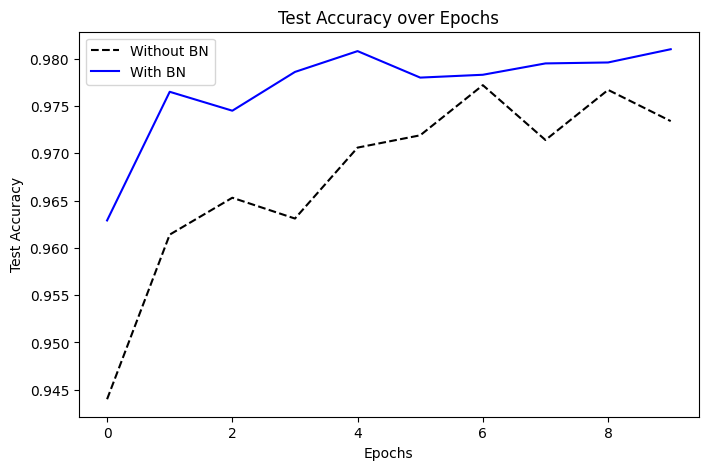

In [7]:
## Let's plot the results 
plt.figure(figsize=(8, 5))
plt.plot(test_acc_no_bn, label='Without BN', linestyle='--', color='black')
plt.plot(test_acc_bn, label='With BN', linestyle='-', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.legend()
plt.title("Test Accuracy over Epochs")
plt.show()

## Takeaways
---
1. Like we can see in the graph. we trained two models on MNIST dataset: one with Batch Normalization (BN) and one without BN.
2. It is clear that the model with BN (blue line) achieves accuracy faster and maintains a more stable performance.
3. The model without BN (black dashed line) improves over time but lags behind the BN model in accuracy.
4. Which indeed proves, **BN accelearates training convergence**.
5. **BN improves generalization**, leading to consistently better test accuracy.
6. **Wihtout BN the model learns more slowly**. 